In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, TextVectorization
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
df = pd.read_csv('../data/df_tokens.csv').drop(columns='Unnamed: 0')
df['Party'] = df['Party'].replace({'Democrat':1, 'Republican':0})
df.head()

,Party,Handle,Tweet,tokens
0,1,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...",today senate dems vote savetheinternet proud s...
1,1,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,winterhavensun winter resident alta vista tea...
2,1,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,nbclatino repdarrensoto noted hurricane maria...
3,1,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,nalcabpolicy meeting repdarrensoto thanks tak...
4,1,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...,vegalteno hurricane season stas june 1st pueo...


In [26]:
df_lda = pd.read_csv('../data/df_with_lda.csv').drop(columns='Unnamed: 0')
df_lda['Party'] = df_lda['Party'].replace({'Democrat':1, 'Republican':0})
df_lda.head()

/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Party,Handle,Tweet,tokens,0,1,2,3,4,5,...,10,11,12,13,14,15,16,17,18,19
0,1,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...",today senate dems vote savetheinternet proud s...,0.07,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.85,0.00
1,1,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,winterhavensun winter resident alta vista tea...,0.01,0.01,0.23,0.01,0.01,0.01,...,0.01,0.23,0.01,0.21,0.01,0.01,0.01,0.01,0.01,0.01
2,1,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,nbclatino repdarrensoto noted hurricane maria...,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.10,0.01,0.01,0.12,0.01,0.01,0.01,0.01
3,1,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,nalcabpolicy meeting repdarrensoto thanks tak...,0.01,0.01,0.01,0.01,0.01,0.86,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
4,1,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...,vegalteno hurricane season stas june 1st pueo...,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.13,0.13,0.01,0.01,0.01,0.01


In [27]:
# There were 4 NaNs even though there were no NaNs when I saved the .csv
df.dropna(inplace=True)

In [28]:
df.isnull().sum()

Party     0
Handle    0
Tweet     0
tokens    0
dtype: int64

In [29]:
# There were 4 NaNs even though there were no NaNs when I saved the .csv
df_lda.dropna(inplace=True)

In [30]:
df_lda.isnull().sum()

Party     0
Handle    0
Tweet     0
tokens    0
0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
dtype: int64

In [31]:
df['Party'] = df['Party'].astype(int)
df['Party']

0        1
1        1
2        1
3        1
4        1
        ..
86456    0
86457    0
86458    0
86459    0
86460    0
Name: Party, Length: 86457, dtype: int64

In [32]:
df_lda['Party'] = df_lda['Party'].astype(int)
df_lda['Party']

0        1
1        1
2        1
3        1
4        1
        ..
86456    0
86457    0
86458    0
86459    0
86460    0
Name: Party, Length: 86457, dtype: int64

# Testing Only with tokens

In [33]:
X = df['tokens']
y = df['Party']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [35]:
cvec = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)

X_train_vec = cvec.fit_transform(X_train)
X_test_vec = cvec.transform(X_test)

In [36]:
y_train.value_counts()

0    33359
1    31483
Name: Party, dtype: int64

### Building a stacked model using GridSearch

In [39]:
lr = LogisticRegression(max_iter=10_000)
rf = RandomForestClassifier(n_estimators=200)
gb = GradientBoostingClassifier()

lr_pipe = Pipeline([
    ('lr', lr)
])

rf_pipe = Pipeline([
    ('rf', rf)
])

gb_pipe = Pipeline([
    ('gb', gb)
])

In [40]:
lr_params = {
    'lr__penalty': ['l2'],
    'lr__C': [0.001,0.01,0.1,1,10,100],
    'lr__class_weight': ['balanced', None]
}
lr_gs = GridSearchCV(lr_pipe, param_grid=lr_params)
lr_gs.fit(X_train_vec, y_train)
print(lr_gs.best_score_)
lr_gs.best_params_

0.7692082586344916


{'lr__C': 1, 'lr__class_weight': None, 'lr__penalty': 'l2'}

In [41]:
rf_params = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 30, 40, 50],
    'rf__min_samples_leaf': [1, 2, 3],
    'rf__min_samples_split': [2, 3, 4, 5] 
}
rf_gs = GridSearchCV(rf_pipe, param_grid=rf_params)
rf_gs.fit(X_train_vec, y_train)
print(rf_gs.best_score_)
rf_gs.best_params_

0.7443478110308028


{'rf__max_depth': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 4,
 'rf__n_estimators': 200}

In [42]:
gb_params = {
    'gb__learning_rate': [.1, .2, .3, .4],
    'gb__n_estimators': [100, 150, 200, 250],
    'gb__max_depth': [2, 3, 4, 5]
}
gb_gs = GridSearchCV(gb_pipe, param_grid=gb_params)
gb_gs.fit(X_train_vec, y_train)
print(gb_gs.best_score_)
gb_gs.best_params_

0.7429906954604272


{'gb__learning_rate': 0.4, 'gb__max_depth': 5, 'gb__n_estimators': 250}

In [45]:
from sklearn.ensemble import StackingClassifier

level_1_models = [         
    ('lr_pipe', Pipeline([
        ('lr', LogisticRegression(C=1, class_weight=None, penalty='l2', max_iter=10_000, solver='lbfgs'))
    ])),
    ('rf_pipe', Pipeline([
        ('rf', RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=200))
    ])),
    ('gb_pipe', Pipeline([
        ('gb', GradientBoostingClassifier(learning_rate=.4, max_depth=5, n_estimators=250))
    ]))]
    
stack = StackingClassifier(estimators=level_1_models, final_estimator=LogisticRegression())

In [47]:
cross_val_score(stack, X_train_vec, y_train).mean()

0.7747602656531741

In [59]:
stack.fit(X_train_vec, y_train);
stack.score(X_train_vec, y_train), stack.score(X_test_vec, y_test)

(0.8966410659757564, 0.7777469349988434)

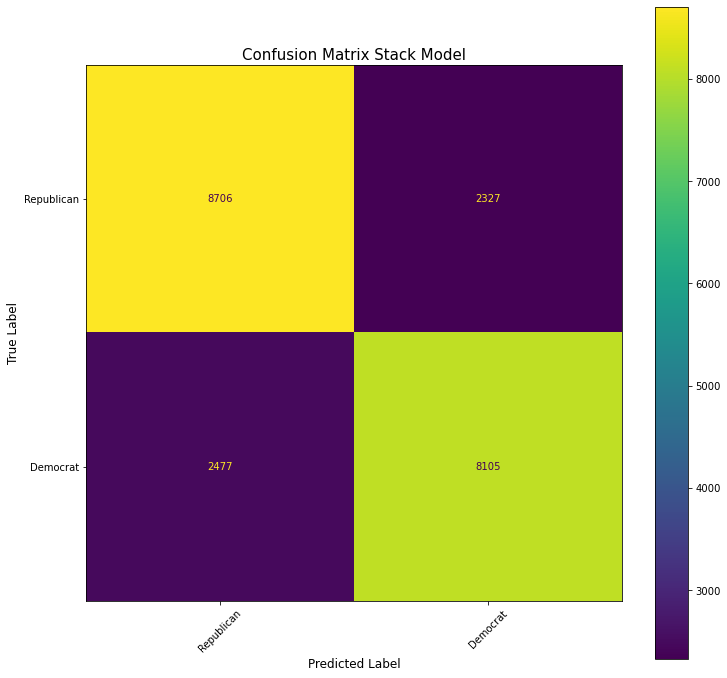

In [62]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(stack, X_test_vec, y_test, display_labels=['Republican', 'Democrat'], cmap='viridis', ax=ax)
plt.xticks(rotation=45)
plt.title('Confusion Matrix Stack Model', size=15)
plt.xlabel('Predicted Label', size=12)
plt.ylabel('True Label', size=12);

In [64]:
y_pred = stack.predict(X_test_vec)

In [65]:
# Inspiration https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro', zero_division=0)))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro', zero_division=0)))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted', zero_division=0)))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


Accuracy: 0.78

Micro Precision: 0.78
Micro Recall: 0.78
Micro F1-score: 0.78

Macro Precision: 0.78
Macro Recall: 0.78
Macro F1-score: 0.78

Weighted Precision: 0.78
Weighted Recall: 0.78
Weighted F1-score: 0.78


In [66]:
X_test[(y_test != y_pred) & (y_pred == 0)]

4087     enjoyed meeting maitland fire chief kimberly n...
26254    great meeting today washington school board le...
29052    realdonaldtrump agree need suppo law enforceme...
5567     currently homeland security mmittee hearing ex...
23982                   happy alohafriday safe fun weekend
                               ...                        
36911    nothing says drain sw like telling room full b...
22385    nation celebrates mlkday honoring life  legacy...
2087     great meeting cal poly president cpprezarmstro...
32571     sylvesteurner evening nimitz hs jrotc celebra...
1592     must ensure america remains nation people back...
Name: tokens, Length: 2477, dtype: object

### Building a NN Classifier

In [53]:
X_train_vec.shape

(64842, 6838)

In [ ]:
#From: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

texts = df['tokens'] 

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_test = data[-nb_validation_samples:]
y_test = labels[-nb_validation_samples:]

In [ ]:
# From: https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
dataset = X_train
max_features = 10_000
max_len = 4

# Create the layer.
vectorize_layer = TextVectorization(
 max_tokens=max_features,
 output_mode='int',
 output_sequence_length=max_len)

# Now that the vocab layer has been created, call `adapt` on the text-only
# dataset to create the vocabulary. You don't have to batch, but for large
# datasets this means we're not keeping spare copies of the dataset.
vectorize_layer.adapt(dataset.batch(64))

# Create the model that uses the vectorize text layer
model = Sequential()

# Start by creating an explicit input layer. It needs to have a shape of
# (1,) (because we need to guarantee that there is exactly one string
# input per batch), and the dtype needs to be 'string'.
model.add(Input(shape=(1,), dtype=tf.string))

# The first layer in our model is the vectorization layer. After this
# layer, we have a tensor of shape (batch_size, max_len) containing vocab
# indices.
model.add(vectorize_layer)

# Now, the model can map strings to integers, and you can add an embedding
# layer to map these integers to learned embeddings.
input_data = [X_test, y_test]
model.predict(input_data)



In [56]:
model = Sequential()

# Input layers, 2 droupouts and an early stop
model.add(Dense(64, 
               activation='relu',
               input_shape=(6838,)))
model.add(Dropout(.5))
model.add(Dense(64,
               activation='relu',))
model.add(Dropout(.5))

early_stop = EarlyStopping(patience=5)

# Output layer
model.add(Dense(1,
               activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
results = model.fit(X_train_vec, y_train,
                   batch_size=64,
                   epochs=100,
                   validation_data=(X_test_vec, y_test),
                   callbacks=[early_stop])

Epoch 1/100


2022-01-11 16:04:23.102248: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: TypeError: 'SparseTensor' object is not subscriptable
Traceback (most recent call last):

  File "/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 273, in __call__
    return func(device, token, args)

  File "/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 151, in __call__
    outputs = self._call(device, args)

  File "/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 158, in _call
    ret = self._func(*args)

  File "/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 649, in wrapper
    return func(*args, **kwargs)

  File "/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/keras/engine/data_adapter.py", line 476, in py_method
    return [slice_array(inp

InvalidArgumentError:  TypeError: 'SparseTensor' object is not subscriptable
Traceback (most recent call last):

  File "/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 273, in __call__
    return func(device, token, args)

  File "/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 151, in __call__
    outputs = self._call(device, args)

  File "/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 158, in _call
    ret = self._func(*args)

  File "/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 649, in wrapper
    return func(*args, **kwargs)

  File "/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/keras/engine/data_adapter.py", line 476, in py_method
    return [slice_array(inp) for inp in flat_inputs]

  File "/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/keras/engine/data_adapter.py", line 476, in <listcomp>
    return [slice_array(inp) for inp in flat_inputs]

  File "/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/keras/engine/data_adapter.py", line 474, in slice_array
    return training_utils.slice_arrays(data, ind.numpy(),

  File "/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training_utils.py", line 47, in slice_arrays
    entries = [[x[i:i + 1] for i in indices] for x in arrays]

  File "/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training_utils.py", line 47, in <listcomp>
    entries = [[x[i:i + 1] for i in indices] for x in arrays]

  File "/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training_utils.py", line 47, in <listcomp>
    entries = [[x[i:i + 1] for i in indices] for x in arrays]

TypeError: 'SparseTensor' object is not subscriptable


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_906]